In [3]:
from pathlib import Path as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
df = pd.read_csv('tour_logs_train.csv')

In [5]:
def currency_conv(df):
    df['Ticket_Price']=df['Ticket_Price'].str.replace("$","")
    df['Ticket_Price']=df['Ticket_Price'].str.replace("USD","")
    df['Ticket_Price']=df['Ticket_Price'].str.replace("Free",'0.0')
    mask = df['Ticket_Price'].str.contains('€', na=False)

    df.loc[mask, 'Ticket_Price'] = (
    df.loc[mask, 'Ticket_Price']
    .str.replace('€', '', regex=False)
    .astype(float)
    * 1.09
    )
    mask = df['Ticket_Price'].str.contains('£', na=False)

    df.loc[mask, 'Ticket_Price'] = (
    df.loc[mask, 'Ticket_Price']
    .str.replace('£', '', regex=False)
    .astype(float)
    * 1.27
    )

def timedate():
    mask1 = df['Show_DateTime'].str.contains(
    r'^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}$',
    na=False
)

    mask2 = df['Show_DateTime'].str.contains(
    r'^\d{2}-\d{2}-\d{4}\s\d{2}:\d{2}$',
    na=False
)

    mask3 = df['Show_DateTime'].str.contains(
    r'^\d{2}/\d{2}/\d{4}\s\d{2}:\d{2}\s[AP]M$',
    na=False
)

    mask4 = df['Show_DateTime'].str.contains(
    r'^[A-Za-z]+\s\d{1,2},\s\d{4}$',
    na=False
)
    valid_mask = mask1|mask2|mask3|mask4
    df.loc[valid_mask, 'Show_DateTime'] = pd.to_datetime(
    df.loc[valid_mask, 'Show_DateTime'],
    errors='coerce',
    dayfirst=True
)


def price(df):
    

# 1. Force the entire column to string type to avoid 'NaN' on numeric rows
    df['Ticket_Price'] = df['Ticket_Price'].astype(str).str.strip()

# 2. Extract Normal Price (the first number in the string)
# [\d.]+ handles any number of digits and dots (like 53.2901)
    df['Normal_price'] = df['Ticket_Price'].str.extract(r'^([\d.]+)')[0]

# 3. Extract VIP Price (number following 'VIP:')
    df['VIP_price'] = df['Ticket_Price'].str.extract(r'VIP:\s*([\d.]+)')[0]

# 4. Fill missing VIP prices with the Normal price
    df['VIP_price'] = df['VIP_price'].fillna(df['Normal_price'])

# 5. Convert both to numeric so you can do math later
    df['Normal_price'] = pd.to_numeric(df['Normal_price'], errors='coerce')
    df['VIP_price'] = pd.to_numeric(df['VIP_price'], errors='coerce')


In [6]:
currency_conv(df)
timedate()
price(df)


In [7]:
df.drop(columns = 'Ticket_Price')

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy,Normal_price,VIP_price
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,464.0,2,Rainy,Waning Crescent,Leather,916,64.96,52.93,52.93
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,388.0,5,Clear,New Moon,Leather,1003,66.42,66.33,66.33
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,679.0,1,Rainy,Waning Crescent,Denim,720,42.58,51.37,51.37
3,Gig_0003,V_Beta,2024-07-08 08:00:00,0,10.0,454.0,1,Rainy,New Moon,Leather,0,0.00,64.77,64.77
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,654.0,5,Cloudy,Full Moon,Spandex,950,67.55,47.34,47.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Gig_1995,V_Alpha,2024-06-16 20:00:00,6,NaN,699.0,5,Stormy,First Quarter,Denim,601,40.67,57.34,57.34
1996,Gig_1996,V_Beta,NaT,3,7.0,588.0,5,Stormy,Full Moon,Spandex,897,65.60,26.94,26.94
1997,Gig_1997,V_Beta,Late Night,4,2.0,649.0,1,Rainy,Waning Gibbous,Leather,670,60.34,57.54,57.54
1998,Gig_1998,V_Beta,NaT,1,9.0,503.0,1,Rainy,Waning Gibbous,Leather,597,150.00,53.37,53.37


In [8]:
V_group = df.groupby(['Venue_ID'])
mask = df['Day_of_Week']>6
mask.sum()
df.head()

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy,Normal_price,VIP_price
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96,52.93,52.93
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42,66.33,66.33
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58,51.37,51.37
3,Gig_0003,V_Beta,2024-07-08 08:00:00,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00,64.77,64.77
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55,47.34,47.34


In [9]:
Week_G = df.groupby('Day_of_Week')
Week_G['Crowd_Energy'].mean()

Day_of_Week
0    54.432987
1    56.372625
2    50.988066
3    56.038382
4    50.754045
5    56.157491
6    60.838328
Name: Crowd_Energy, dtype: float64

In [10]:
en_val = Week_G['Crowd_Energy'].mean()
m_e = en_val.mean()




In [54]:
def c_e():
    mask = (df['Crowd_Energy'] > 100) | (df['Crowd_Energy'] < 0)
    df.loc[mask, 'Crowd_Energy'] = np.nan
def price():
    mask = (df['Normal_price'] >110) | (df['Normal_price']<0)
    df.loc[mask,'Normal_price'] = np.nan
def v_l():
    mask = (df['Volume_Level'] > 11) | (df['Volume_Level'] < 1)
    df.loc[mask, 'Volume_Level'] = np.random.choice([10,11])
def c_s():
    mask = (df['Crowd_Size'] >1050) | (df['Crowd_Size']<0)
    df.loc[mask,'Crowd_Size'] = np.nan
def t_c():
    mask = df['Show_DateTime'].str.contains('Eve|Mor|Night|noon', na=False)
    df.loc[mask, 'Show_DateTime'] = pd.NaT

c_e()
price()
v_l()
c_s()
t_c()

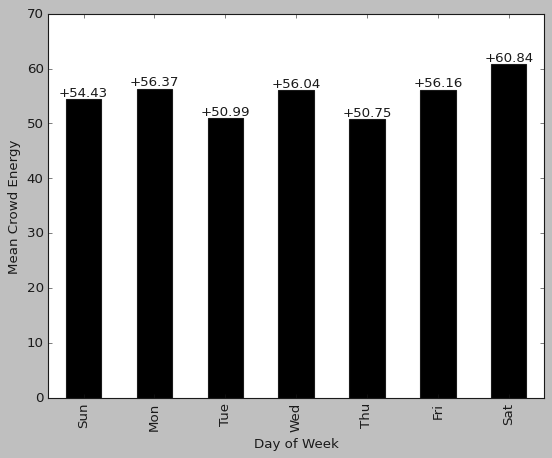

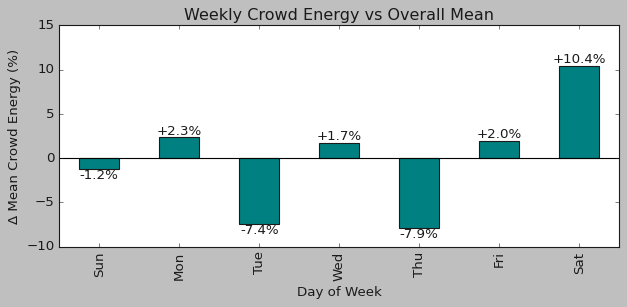

In [55]:
plt.style.use('classic')

en_val.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
ax1 = en_val.plot(kind='bar', color = 'black')

ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Mean Crowd Energy')
for i, v in enumerate(en_val):
    ax1.text(i, v, f"{v:+.2f}", ha='center',
            va='bottom' if v >= 0 else 'top')
plt.show()
delta_pct = (en_val-m_e)*1.0/m_e*100.0
ax = delta_pct.plot(kind='bar', figsize=(8, 4), color = 'teal')

ax.axhline(0, color='black', linewidth=1)  # zero reference line
ax.set_xlabel('Day of Week')
ax.set_ylabel('Δ Mean Crowd Energy (%)')
ax.set_title('Weekly Crowd Energy vs Overall Mean')
for i, v in enumerate(delta_pct):
    ax.text(i, v, f"{v:+.1f}%", ha='center',
            va='bottom' if v >= 0 else 'top')


plt.tight_layout()
plt.show()


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def pleron(df):
    '''
    Plots Day of week vs Mean Crowd Energy, including Crowd Size context 
    and Energy Variance.
    '''
    # --- 1. Data Processing ---
    # Group by Day_of_Week and get mean for BOTH metrics
    week_group = df.groupby('Day_of_Week')
    week_energy = week_group['Crowd_Energy'].mean()
    week_size = week_group['Crowd_Size'].mean()
    
    overall_mean_energy = df['Crowd_Energy'].mean()
    delta_pct_energy = (week_energy - overall_mean_energy) / overall_mean_energy * 100

    # Map to Day Names (Assuming data is 0-6 or ordered Sun-Sat)
    day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    week_energy.index = day_names
    week_size.index = day_names
    delta_pct_energy.index = day_names

    # --- 2. Aesthetic Setup ---
    sns.set_style("white")
    # Share x-axis to align days
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Weekly Crowd Energy & Size Analysis', fontsize=20, fontweight='bold', y=0.98)

    # --- 3. Plot 1: Energy (Bars) + Size (Line) ---
    
    # Primary Y-Axis: Crowd Energy (Bars)
    sns.barplot(
        x=week_energy.index, 
        y=week_energy.values, 
        ax=ax1, 
        palette="flare", 
        hue=week_energy.index, 
        legend=False,
        alpha=0.85 # Slight transparency so the line pops
    )
    
    ax1.set_ylabel('Mean Energy Index', fontweight='semibold')
    ax1.set_title('Average Energy Levels vs. Crowd Size', fontsize=14, loc='left', pad=10)
    
    # Annotate Energy values on bars
    for i, v in enumerate(week_energy):
        ax1.text(i, v + 1, f"{v:.1f}", ha='center', fontweight='bold', color='#333333')

    # Secondary Y-Axis: Crowd Size (Line)
    ax1_twin = ax1.twinx()
    color_size = '#2c3e50' # A distinct dark blue-grey
    
    sns.lineplot(
        x=week_size.index, 
        y=week_size.values, 
        ax=ax1_twin, 
        color=color_size, 
        marker='o', 
        markersize=8,
        linewidth=3,
        label='Mean Crowd Size'
    )
    
    ax1_twin.set_ylabel('Mean Crowd Size', fontweight='semibold', color=color_size)
    ax1_twin.tick_params(axis='y', labelcolor=color_size)
    ax1_twin.grid(False) # Turn off grid for secondary axis to reduce clutter

    # --- 4. Plot 2: Delta Percentage (Energy) ---
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in delta_pct_energy]
    sns.barplot(
        x=delta_pct_energy.index, 
        y=delta_pct_energy.values, 
        ax=ax2, 
        palette=colors, 
        hue=delta_pct_energy.index, 
        legend=False
    )
    
    ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax2.set_title('Energy Variance from Weekly Average (%)', fontsize=14, loc='left', pad=10)
    ax2.set_ylabel('% Difference', fontweight='semibold')
    ax2.set_xlabel('Day of the Week', fontweight='semibold')

    for i, v in enumerate(delta_pct_energy):
        va_pos = 'bottom' if v > 0 else 'top'
        offset = 1 if v > 0 else -3
        ax2.text(i, v + offset, f"{v:+.1f}%", ha='center', fontweight='bold', color='black')

    # --- 5. Final Polishing ---
    # We keep the right spine on ax1 because it holds the Crowd Size axis
    sns.despine(ax=ax1, right=False) 
    sns.despine(ax=ax2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

def vopin(df):  
    '''
    Plots Volume Level against both Crowd Energy and Crowd Size 
    in a side-by-side comparison.
    '''
    # 1. Set a professional theme
    sns.set_theme(style="whitegrid", rc={"axes.grid": False})

    # 2. Create a figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Impact of Volume Level", fontsize=20, fontweight='bold', y=0.98)

    # --- Plot 1: Volume vs. Crowd Energy ---
    sns.regplot(
        data=df, 
        x="Volume_Level", 
        y="Crowd_Energy", 
        ax=ax1,
        color="#2c3e50",       # Professional Blue/Grey
        scatter_kws={'alpha': 0.5, 's': 60},
        line_kws={'linewidth': 3, 'color': '#e74c3c'} # Red trend line
    )
    
    ax1.set_title("Volume vs. Crowd Energy", fontsize=14, pad=15)
    ax1.set_xlabel("Volume Level (dB)", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Crowd Energy Index", fontsize=12, fontweight='bold')

    # --- Plot 2: Volume vs. Crowd Size ---
    sns.regplot(
        data=df, 
        x="Volume_Level", 
        y="Crowd_Size", 
        ax=ax2,
        color="#27ae60",       # Emerald Green for differentiation
        scatter_kws={'alpha': 0.5, 's': 60},
        line_kws={'linewidth': 3, 'color': '#2c3e50'} # Dark trend line
    )
    
    ax2.set_title("Volume vs. Crowd Size", fontsize=14, pad=15)
    ax2.set_xlabel("Volume Level (dB)", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Total Crowd Size", fontsize=12, fontweight='bold')

    # 3. Final Polish
    sns.despine()  # Remove top and right borders
    plt.tight_layout() # Fix overlap issues
    plt.show()

# Usage:
# vopin(df)

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

def pomic(df):
    """
    Plots Crowd Size vs. Crowd Energy with a stylized JointGrid.
    Fixed: Uses 'linewidth' instead of 'weight' for the regression line.
    """
    # 1. Aesthetic Setup
    sns.set_context("talk")
    sns.set_style("white", {'axes.grid': False})
    
    # 2. Initialize JointGrid
    g = sns.JointGrid(data=df, x='Crowd_Size', y='Crowd_Energy', height=8)

    # 3. Define the Main Plot (The Center)
    # FIX: changed 'weight' to 'linewidth' in line_kws
    g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha': 0.3, 'color': '#2c3e50', 's': 50},
                 line_kws={'color': '#e74c3c', 'linewidth': 4})

    # 4. Define the Marginal Plots (Top and Right)
    g.plot_marginals(sns.histplot, kde=True, color='#2ecc71', alpha=0.4, element="step")

    # 5. Adding the Reference Lines (Peaks at 50 and 30)
    

    # 6. Custom Formatting
    g.fig.suptitle('Crowd Dynamics: Size vs. Energy', 
                   fontsize=22, fontweight='bold', y=1.05)
    
    g.ax_joint.set_xlabel('Total Crowd Size', fontsize=14, fontweight='semibold')
    g.ax_joint.set_ylabel('Crowd Energy Index', fontsize=14, fontweight='semibold')
    
    # Clean up the borders
    sns.despine(fig=g.fig)
    
    # Add a legend for the reference lines
    
    
    plt.show()

# Usage:
# pomic(va)

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

def ulot(df, category_col, size_col='Crowd_Size', energy_col='Crowd_Energy'):
    grouped = df.groupby(category_col)[[size_col, energy_col]].mean().sort_values(size_col)
    
    sns.set_style("white")
    fig, ax1 = plt.subplots(figsize=(12, 6)) # Increased width slightly

    # Plot 1: Crowd Size (Bars)
    color_size = '#95a5a6'
    sns.barplot(x=grouped.index, y=grouped[size_col], ax=ax1, 
                color=color_size, alpha=0.5, edgecolor='none')
    
    ax1.set_ylabel('Avg. Crowd Size', color=color_size, fontweight='bold')
    ax1.set_xlabel(category_col, fontweight='bold')
    
    # --- THE FIX ---
    # Rotate x-axis labels to prevent overlap
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Plot 2: Crowd Energy (Line/Points)
    ax2 = ax1.twinx()
    color_energy = '#e74c3c'
    sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2, 
                  color=color_energy, markers='D', scale=1.1)
    
    ax2.set_ylabel('Avg. Crowd Energy', color=color_energy, fontweight='bold')
    
    plt.title(f'{category_col}: Impact on Size & Energy', fontsize=16)
    sns.despine(ax=ax1, right=False)
    ax2.grid(False)
    
    plt.tight_layout() # Ensures the rotated labels don't get cut off
    plt.show()

In [68]:
def horen(df, time_col='Show_DateTime', size_col='Crowd_Size', energy_col='Crowd_Energy'):
    # 1. Preprocessing: Extract the Hour
    # Ensure it's a datetime object
    df[time_col] = pd.to_datetime(df[time_col])
    # Create a new column for the hour (0-23)
    df['Hour_of_Day'] = df[time_col].dt.hour
    
    # Group by Hour
    grouped = df.groupby('Hour_of_Day')[[size_col, energy_col]].mean()

    # 2. Setup
    sns.set_style("darkgrid") # Grid helps read time-series data
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 3. Plot Crowd Size (Area Fill - Left Axis)
    color_size = '#3498db' # Blue
    ax1.fill_between(grouped.index, grouped[size_col], color=color_size, alpha=0.3)
    ax1.plot(grouped.index, grouped[size_col], color=color_size, linewidth=1.5)
    
    ax1.set_ylabel('Crowd Size', color=color_size, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_size)
    ax1.set_xlabel('Hour of Day (24h)', fontsize=12, fontweight='bold')
    
    # Fix X-axis to show all hours present in data
    ax1.set_xticks(grouped.index)

    # 4. Plot Crowd Energy (Line - Right Axis)
    ax2 = ax1.twinx()
    color_energy = '#f1c40f' # Sunflower Yellow
    ax2.plot(grouped.index, grouped[energy_col], color=color_energy, 
             linewidth=3, linestyle='--', marker='o')
    
    ax2.set_ylabel('Crowd Energy', color=color_energy, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_energy)
    ax2.grid(False)

    plt.title('Hourly Dynamics: Size vs. Energy', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Usage:
# plot_hourly_trend(df, 'Your_Time_Column_Name')

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def hovol(df):
    """
    Extracts the hour (0-23) from the 'date' column and plots 
    the trend of Volume_Level throughout the day.
    """
    # 1. Data Processing
    # Ensure 'date' is in datetime format
    df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'])
    
    # Extract the hour (24-hour format)
    df['Hour_of_Day'] = df['Show_DateTime'].dt.hour
    
    # 2. Aesthetic Setup
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))
    
    # 3. Create the Plot
    # sns.lineplot automatically calculates the mean and draws a confidence interval (shadow)
    sns.lineplot(
        data=df, 
        x='Hour_of_Day', 
        y='Volume_Level',
        color='#8e44ad',       # A distinct purple
        linewidth=3,
        marker='o',            # Add dots for each hour
        markersize=8
    )
    
    # 4. Customizing the Axis
    plt.title("Average Volume Level by Hour of Day", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Hour (24h Format)", fontsize=12, fontweight='bold')
    plt.ylabel("Volume Level (dB)", fontsize=12, fontweight='bold')
    
    # Force x-axis to show all hours (0, 1, 2... 23) if possible, or reasonable steps
    plt.xticks(range(0, 24))
    plt.xlim(0, 23)
    
    # 5. Final Polish
    plt.tight_layout()
    plt.show()

# Usage:
# plot_hourly_volume(df)

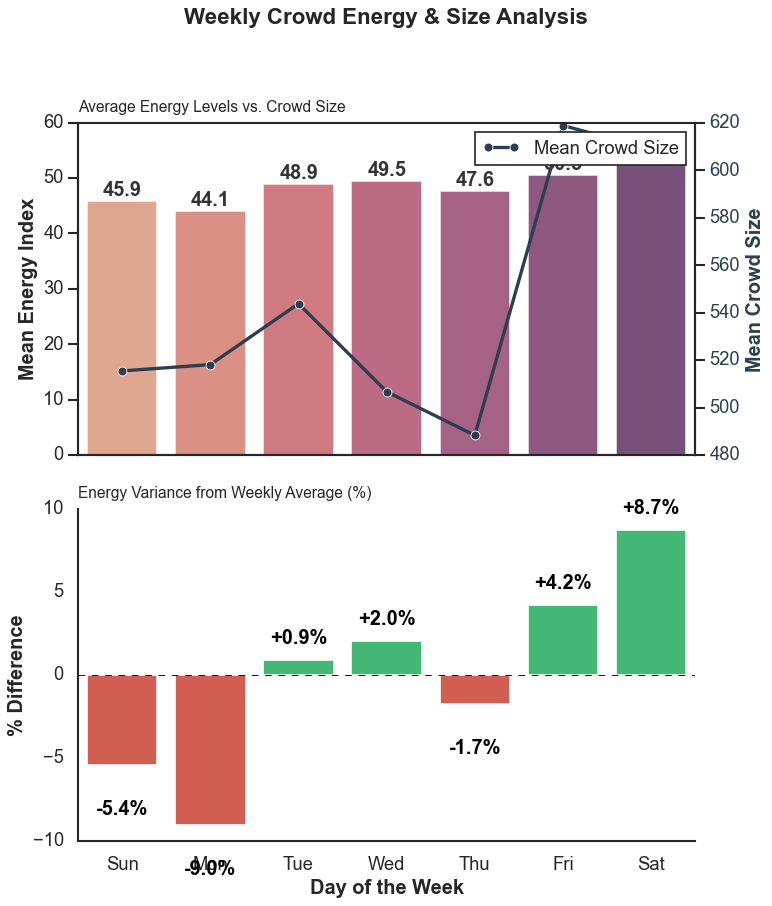

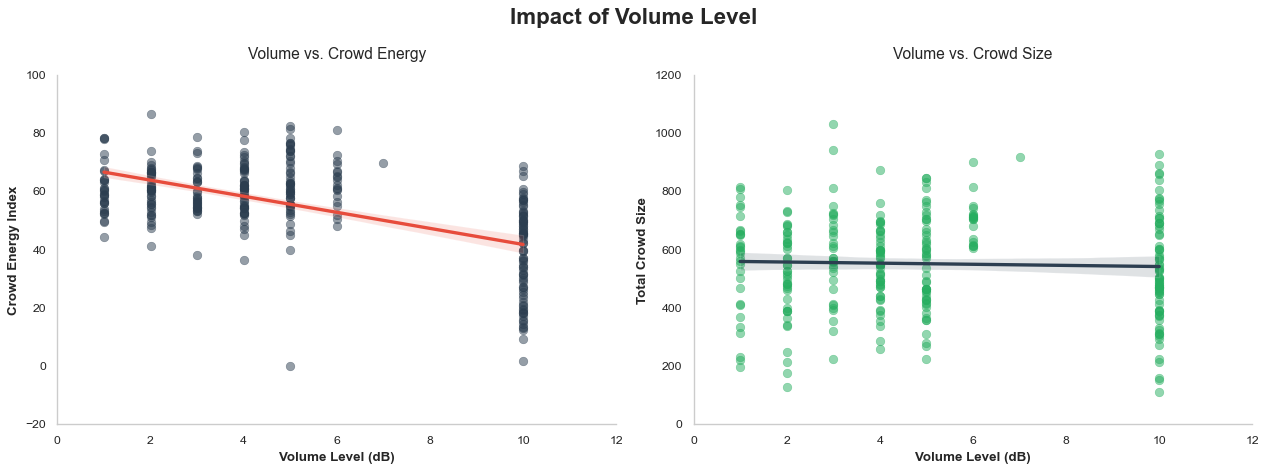

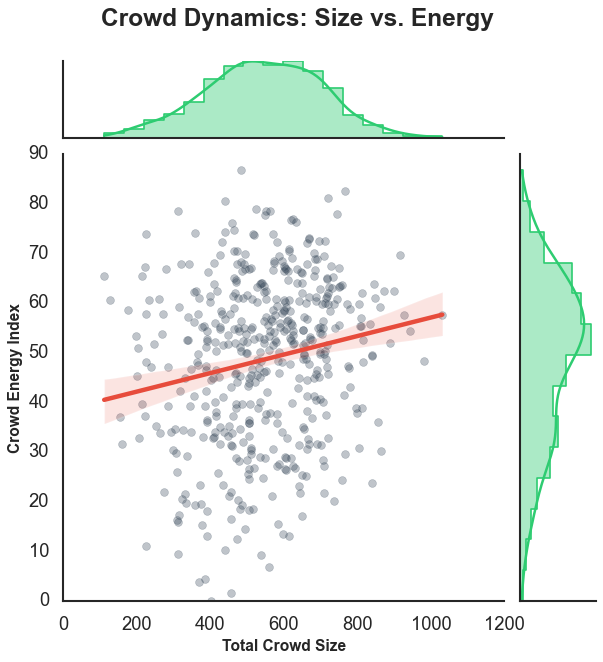

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


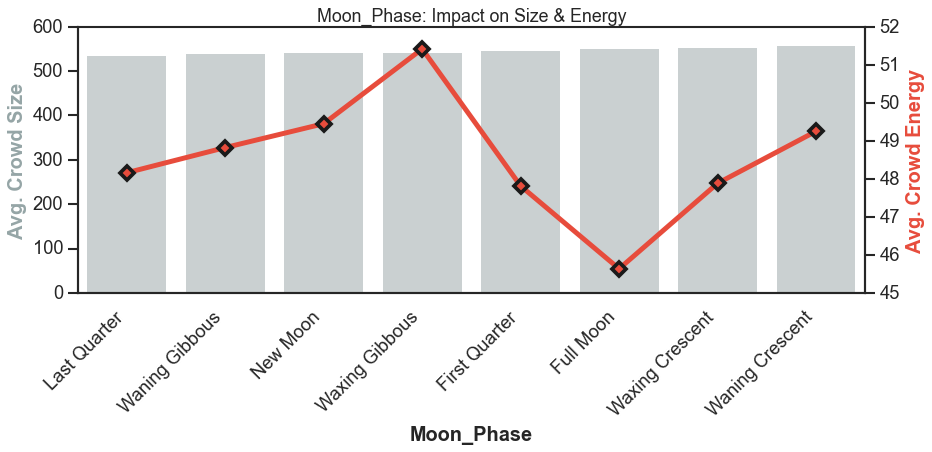

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


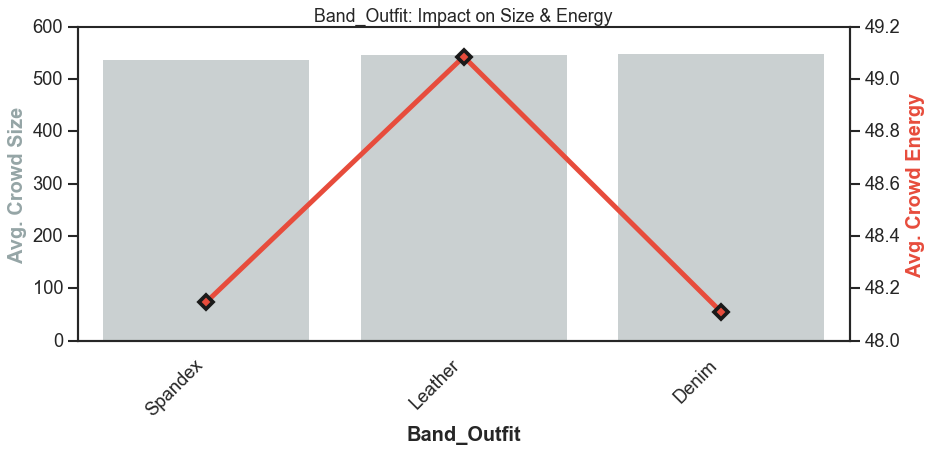

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


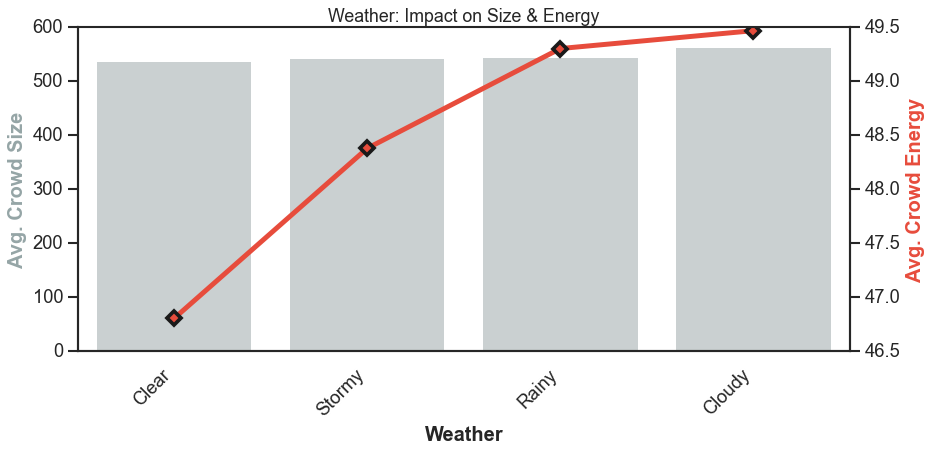

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_of_Day'] = df[time_col].dt.hour


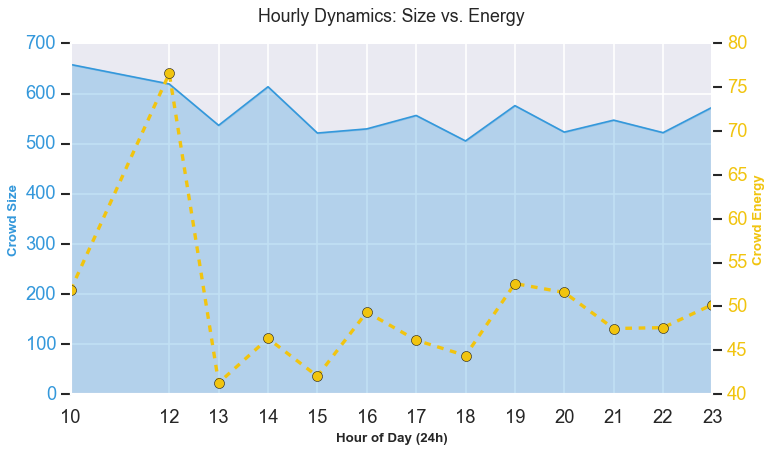

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\1210738997.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'])
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\1210738997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_of_Day'] = df['Show_DateTime'].dt.hour


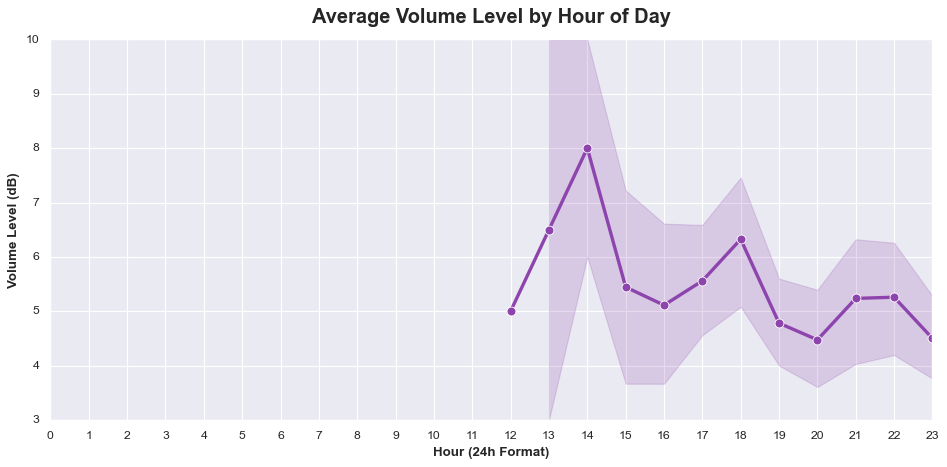

In [74]:
#Data for v_alpha

va = V_group.get_group(('V_Alpha',))
pleron(va)
#Hence Mondays are bad for holy pit, saturdays are best
#Fridays and saturdays have max crowd size with good crowd energy, thus maximum profitability is on these days.
#Thursdays had least crowd but they were not too pessimist on crowd energy, it shows that crowd size is not the main factor for crowd energy
#monday and sunday have least energy with moderately low crowd size.
#Tuesdays are not as bad as expected
vopin(va)
#the saints like low volume, crowd energy has highest probability at around 50, another peak is observed at around 30, definitely go for 2dB here
#they dont know what volume to expect, this checks out in data as well
pomic(va)
#crowd energy and corwd size are too scatterred, it is not possible to infer anyhthing useful
ulot(va,'Moon_Phase')
#the idea that full moon were best is false for this venue, however there is a clear gradual increase in energy from full moon to waxing gibbous,\
#the crowd size is completely consistent for the moon phases
ulot(va,'Band_Outfit')
#the crowd doesnt know what cloth to expect but its energy is affected, leather outfits work here the best with an inverted 'V' apex 
ulot(va,'Weather')
#attendence is barely affected by weather however energy clearly preeferss a chaotic weather
horen(va)
#crowd doesnt care of the time, but energy peaks at noon, while slops at noon+1, highly volatile, late night shows are more safe,but morning 10-12 is worth taking the risk sometimes

#crowd size is mostly affected by day of week
#volume, time of day affects crowd energy lets test which is true or were they overlapping
hovol(va)
#hence low volume and time do intercept and make the energy better but time has still some role, as theres low volume at evenings as well but the crowd doesnt recieve it with as much energy.


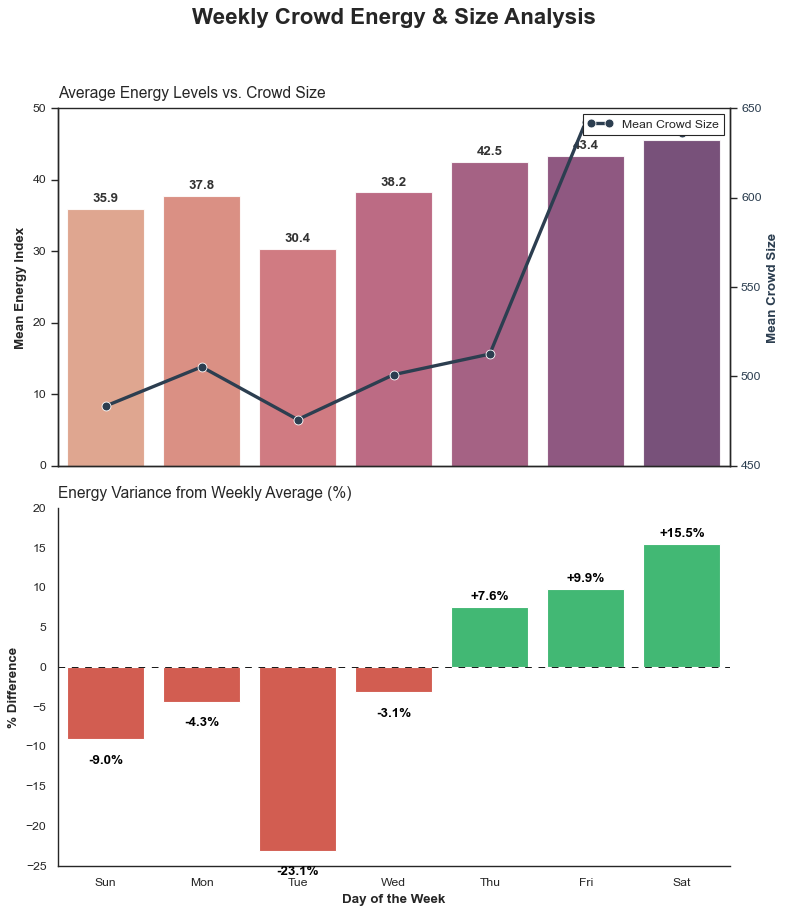

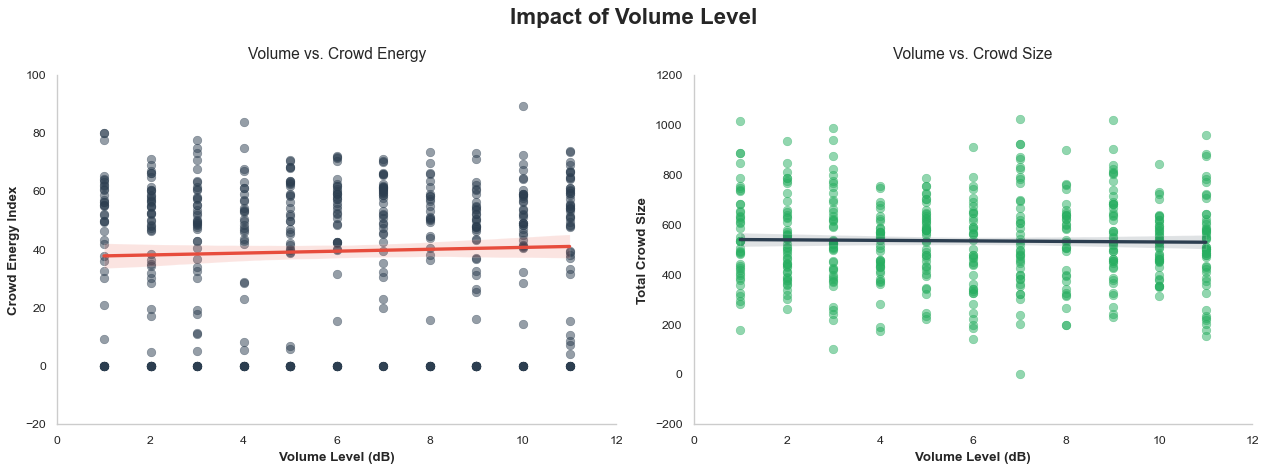

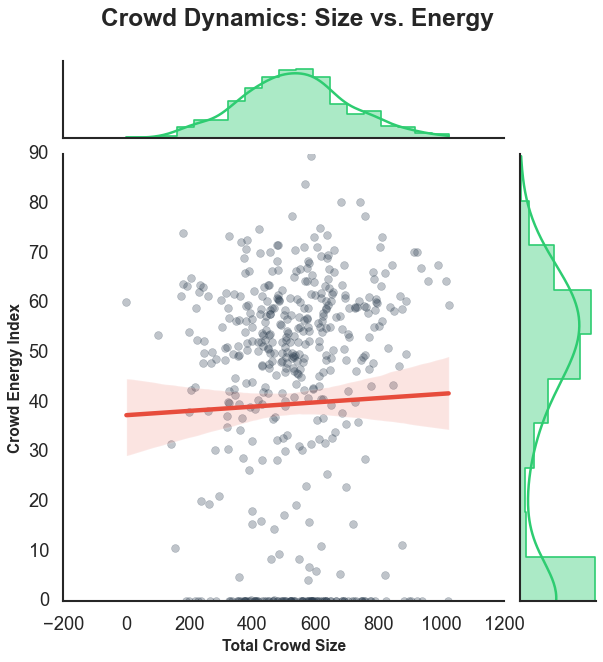

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


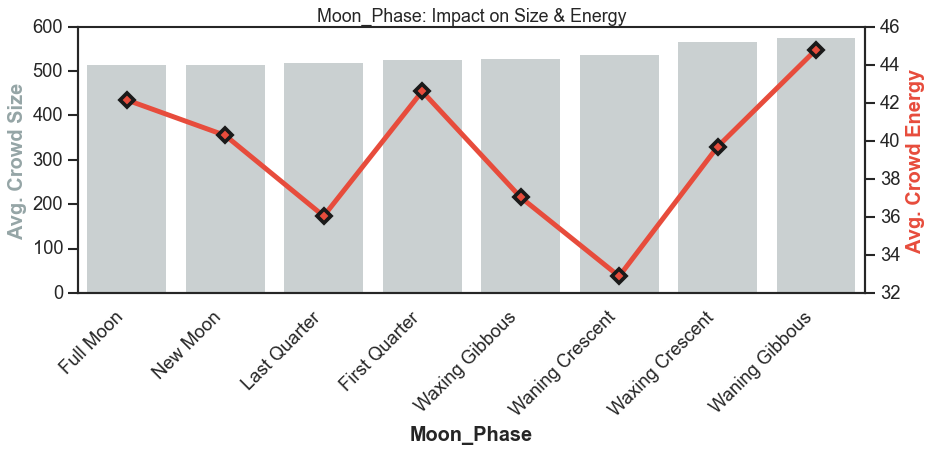

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


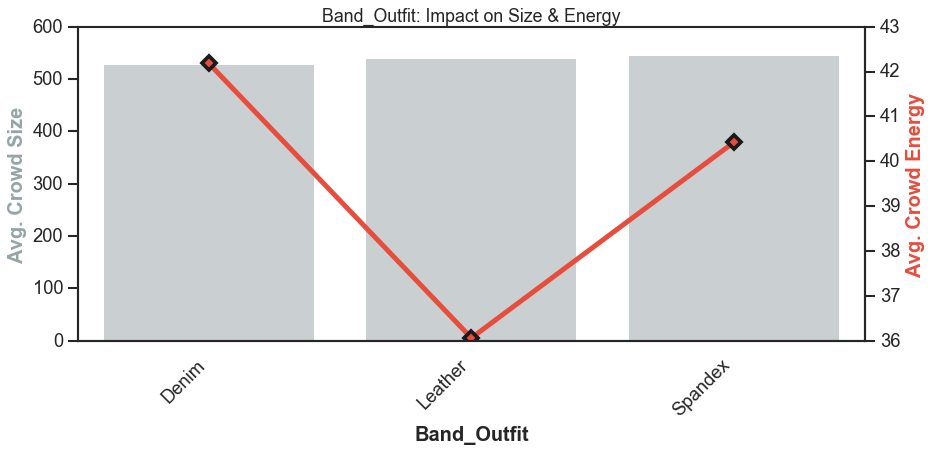

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


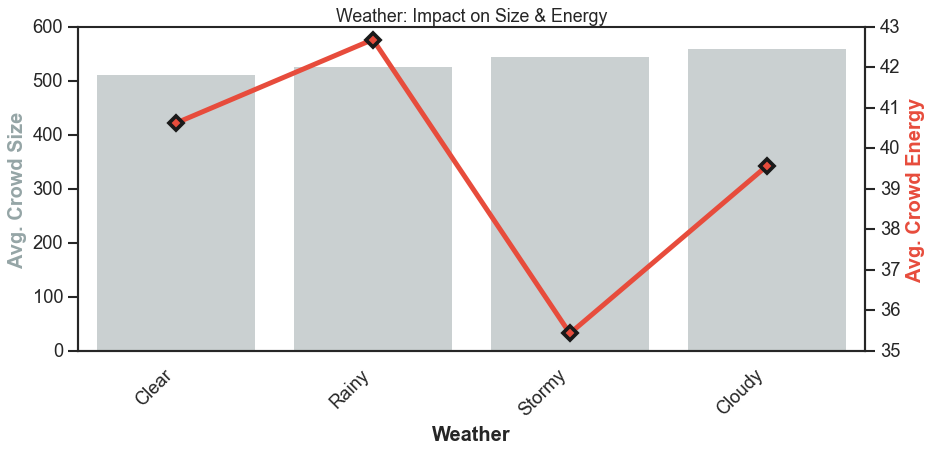

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_of_Day'] = df[time_col].dt.hour


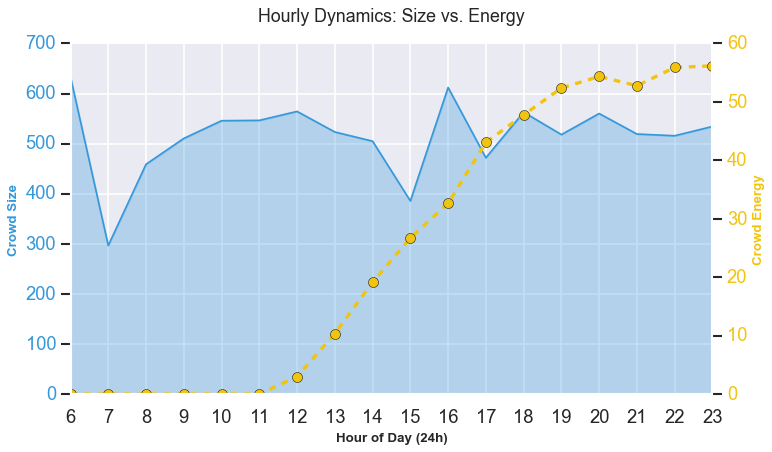

In [75]:
#data for v_beta

vb = V_group.get_group(('V_Beta',))
pleron(vb)

vopin(vb)

pomic(vb)

ulot(vb,'Moon_Phase')
ulot(vb,'Band_Outfit')
ulot(vb,'Weather')

horen(vb)

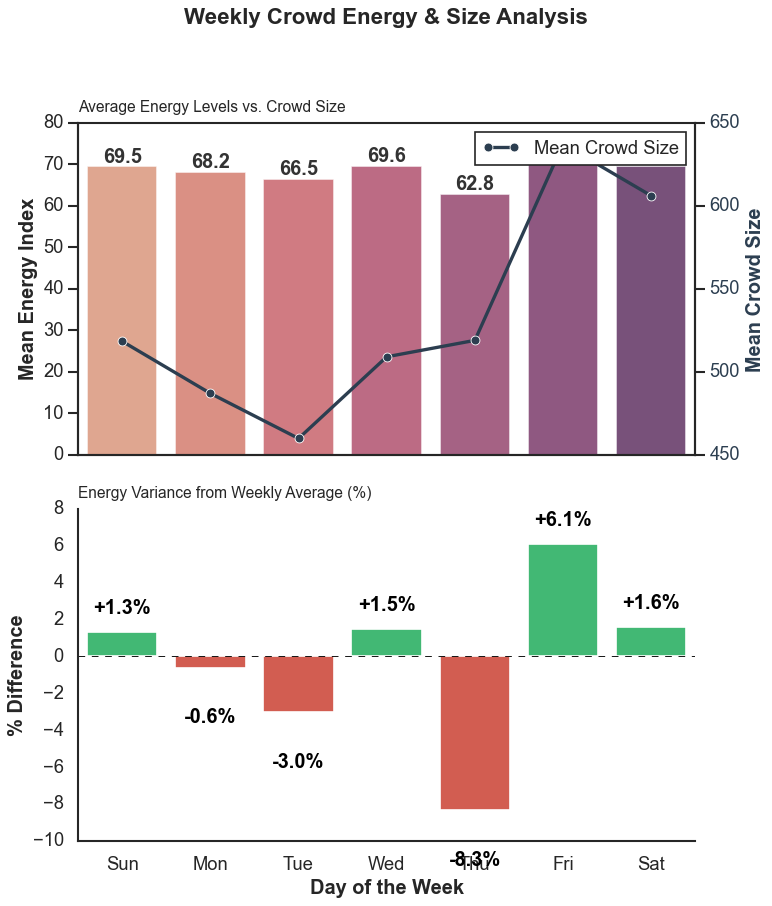

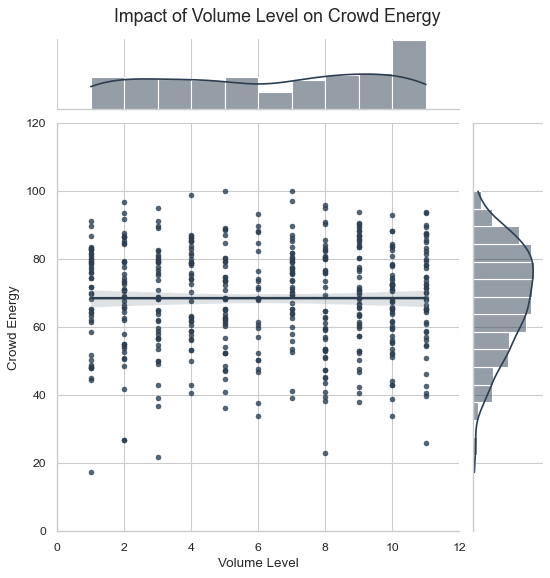

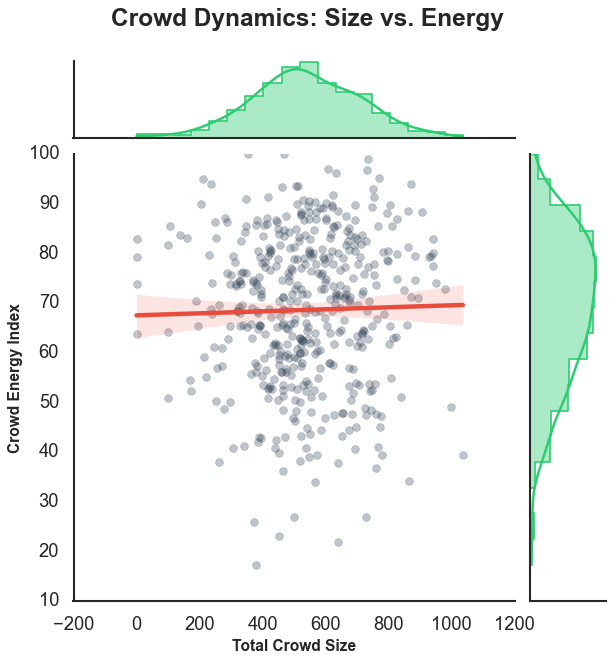

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


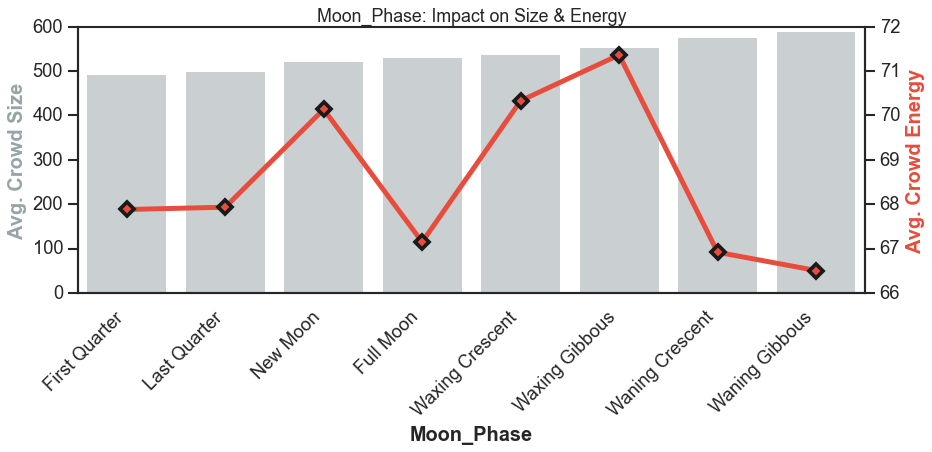

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


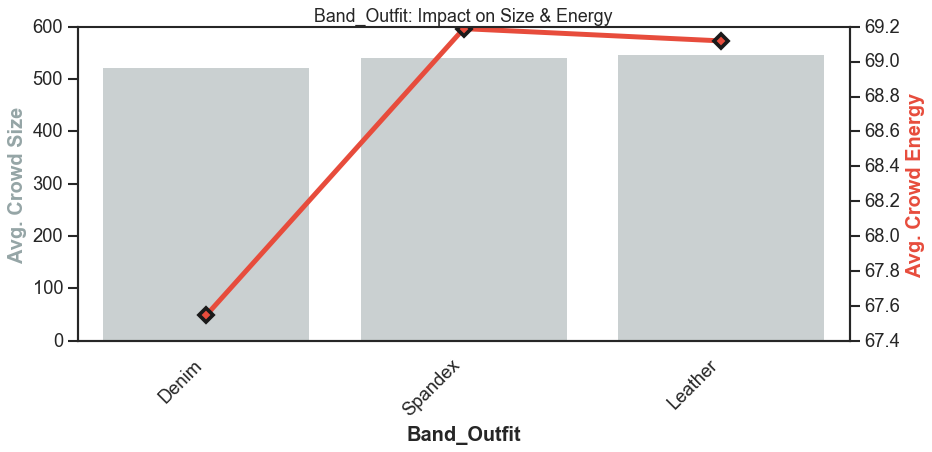

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


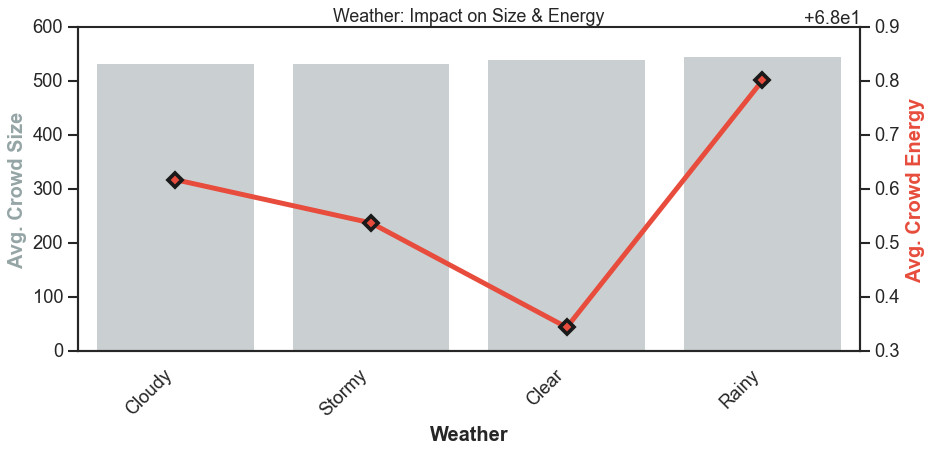

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_of_Day'] = df[time_col].dt.hour


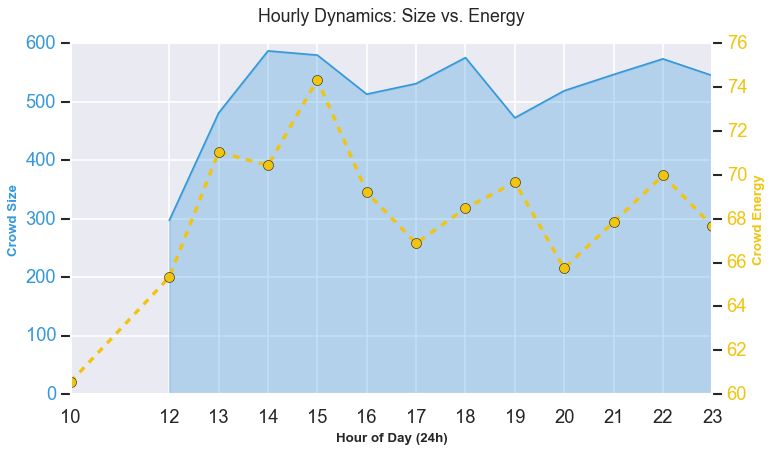

In [63]:
#data for v_gamma

vg = V_group.get_group(('V_Gamma',))
pleron(vg)

vopin(vg)

pomic(vg)

ulot(vg,'Moon_Phase')
ulot(vg,'Band_Outfit')
ulot(vg,'Weather')

horen(vg)

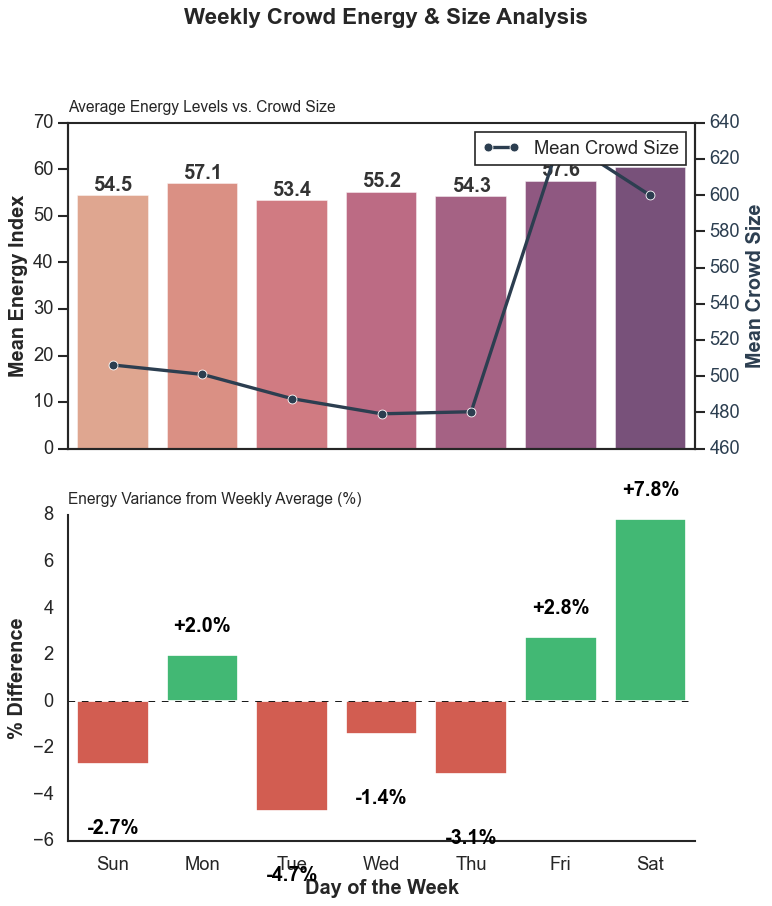

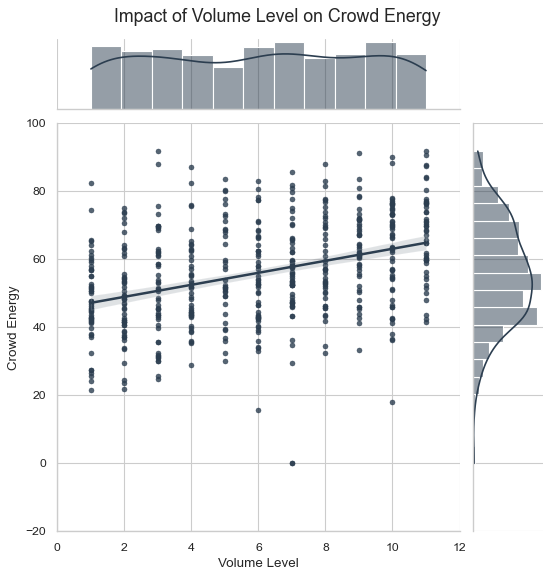

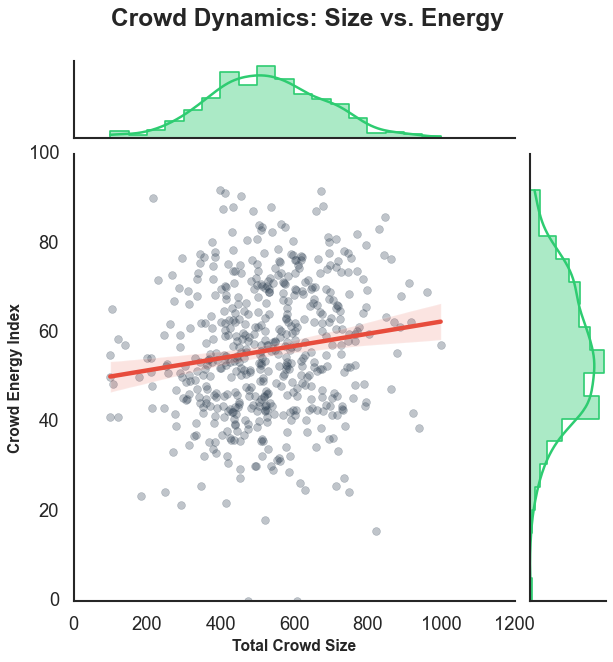

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


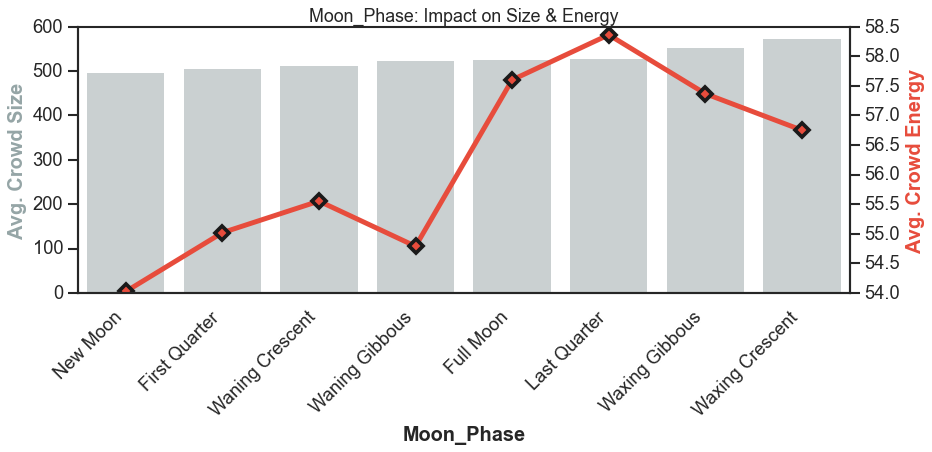

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


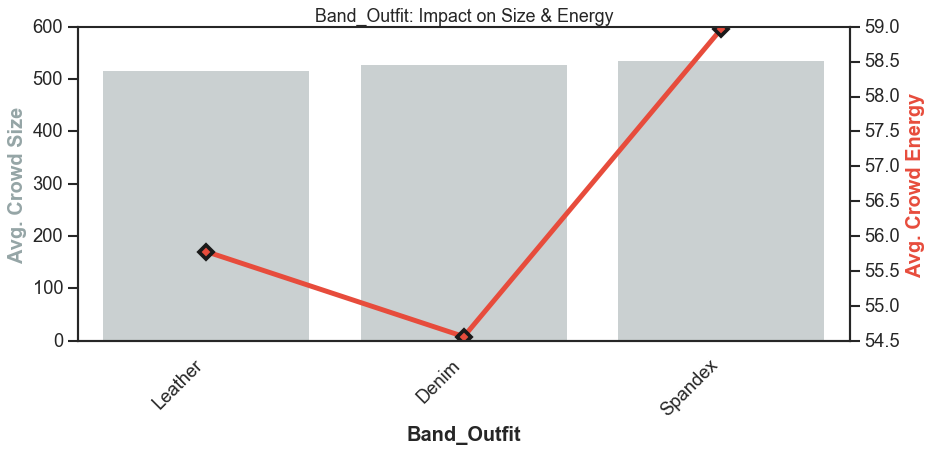

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\2169709581.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=grouped.index, y=grouped[energy_col], ax=ax2,


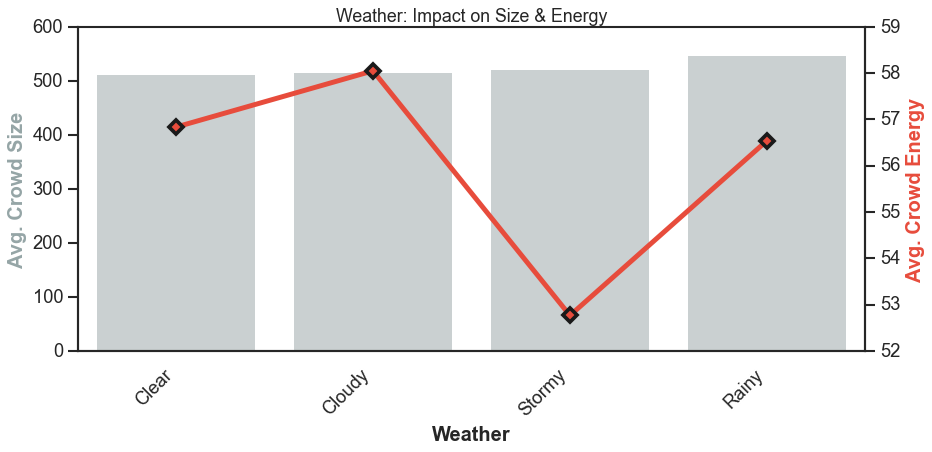

C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])
C:\Users\Anurag Priyam Sahay\AppData\Local\Temp\ipykernel_23868\4191134175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_of_Day'] = df[time_col].dt.hour


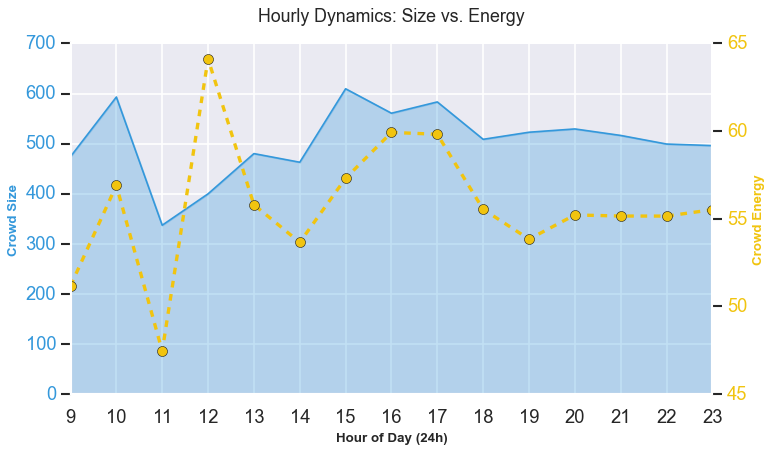

In [64]:
#data for v_delta

vd = V_group.get_group(('V_Delta',))
pleron(vd)

vopin(vd)

pomic(vd)

ulot(vd,'Moon_Phase')
ulot(vd,'Band_Outfit')
ulot(vd,'Weather')

horen(vd)